In [1]:
from sklearn.metrics import plot_roc_curve, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


%load_ext pycodestyle_magic


In [2]:
import os
os.environ['QT_QPA_PLATFORM'] = 'offscreen'


In [3]:
# %%pycodestyle
def load_data(path):
    '''
      Returns a pandas DataFrame for the CSV found at `path`
      input:
              pth: a path to the CSV file
    '''
    return pd.read_csv(path)


In [4]:
def clean_data():
    '''
    remvoe unused column and add `Churn`

    input : pandas dataframe

    output: clean dataframe 
    '''
    df = load_data(r"./data/bank_data.csv")
    df.drop('Unnamed: 0', inplace=True, axis=1)
    df['Churn'] = df['Attrition_Flag'].apply(
        lambda val: 0 if val == "Existing Customer" else 1)

    return df


In [5]:
def hist_plot(dataframe, column):
    '''
    Returns : histogram 

    inputs: 
           dataframe: pandas df
           column: coulmn for plotting       
    '''
    plt.figure(figsize=(20, 10))
    plt.title(f'{column} avg')
    plt.xlabel(column)
    plt.ylabel('freq')
    dataframe[column].hist()


In [6]:
def bar_plot(dataframe, column):
    '''
    Returns : bar chart 

    inputs: 
           dataframe: pandas df
           column: coulmn for plotting       
    '''
    plt.figure(figsize=(20, 10))
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('freq')
    dataframe[column].value_counts('normlaize').plot(kind='bar')


In [7]:
def dist_plot(dataframe, column):
    '''
    Returns : bar chart 

    inputs: 
           dataframe: pandas df
           column: coulmn for plotting       
    '''
    plt.figure(figsize=(20, 10))
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('freq')
    sns.distplot(dataframe[column])


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


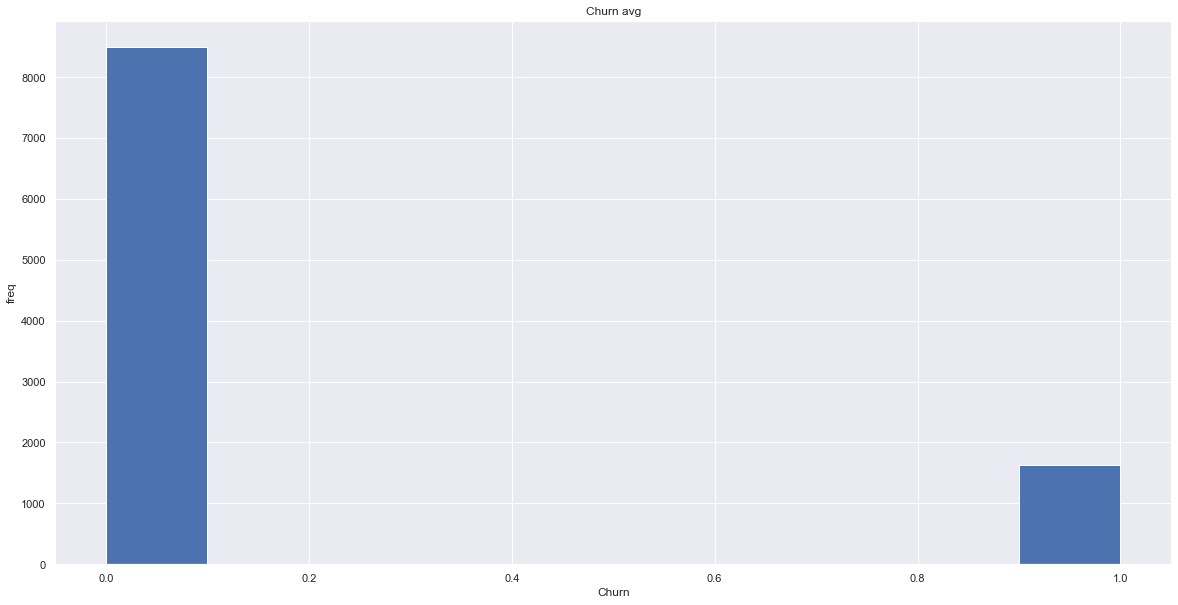

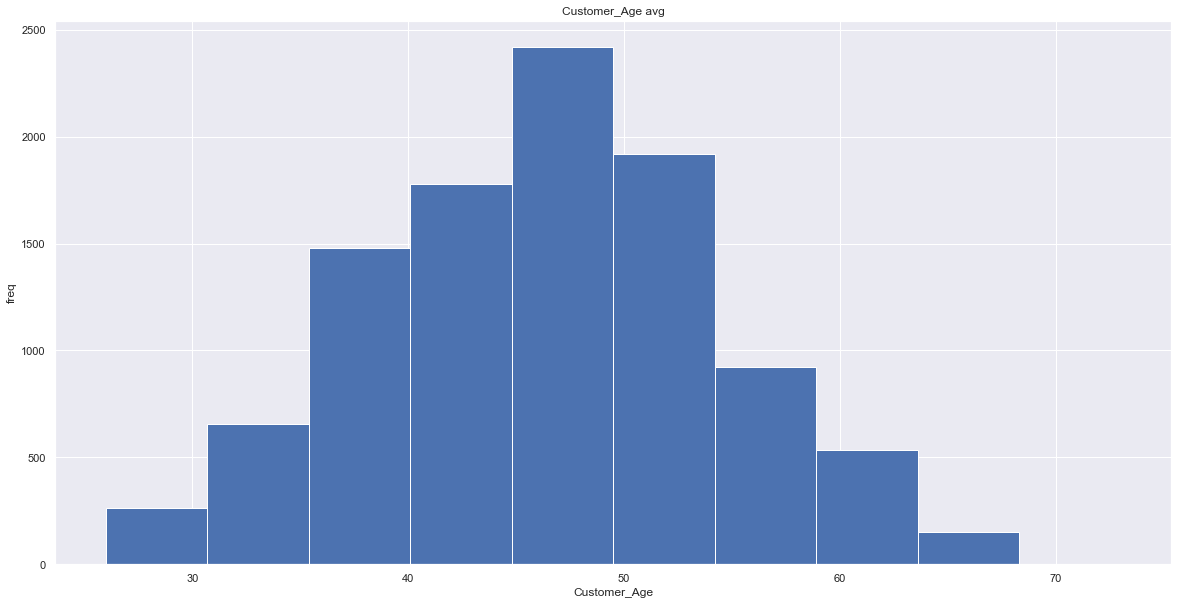

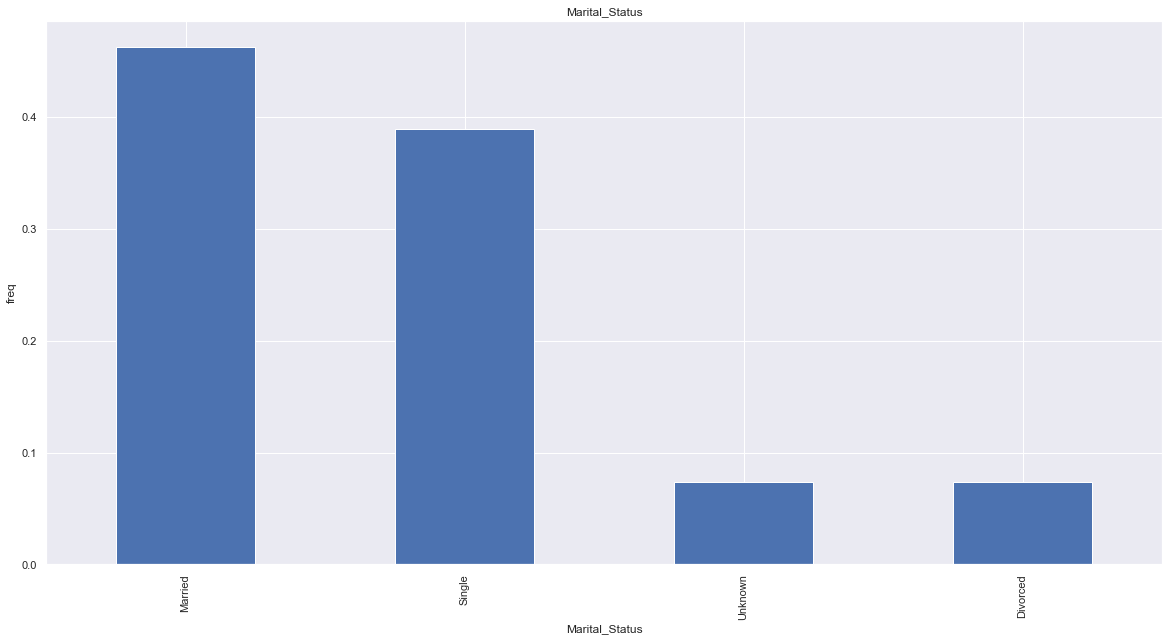

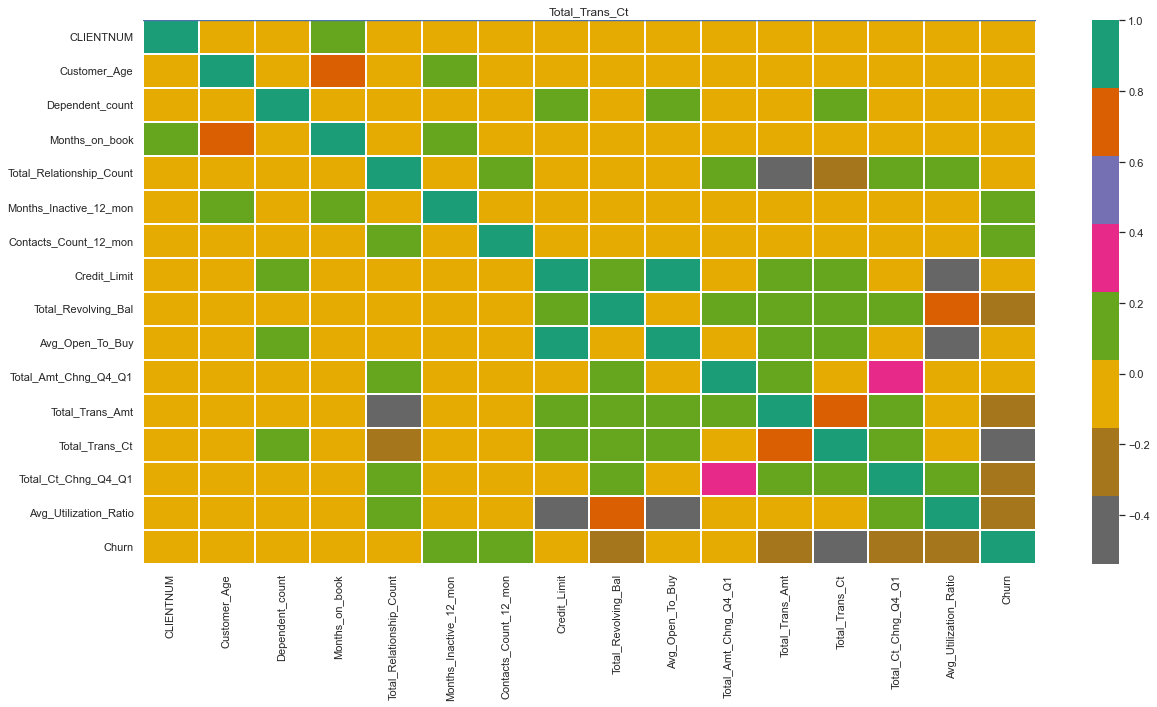

In [8]:
def eda(df):
    '''
      Returns plots  for analysis'
      input: panads data frame
      output: stastics info and plots
    '''
    hist_plot(df, 'Churn')
    hist_plot(df, 'Customer_Age')
    bar_plot(df, 'Marital_Status')
    dist_plot(df, 'Total_Trans_Ct')
    sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths=2)


eda(clean_data())


```python
cat_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'                
]

quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]  
```  

In [9]:
def encode_columns(dataframe, columns):
    '''
    preforme data encoding on  cloumns 

    input:
            dataframe: pandas data frame 
    output:
            dataframe: pandas df with  encoding 
    '''
    df = dataframe.copy()
    for col in columns:
        column_groups = df.groupby(col).mean()['Churn']
        column_lst = [column_groups.loc[val] for val in df[col]]
        df[f'{col}_Churn'] = column_lst

    return df


In [10]:
df = clean_data()
encoded_df = encode_columns(
    df, ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'])


### Model Traning 

In [11]:
def data_split(dataframe):
    df = dataframe.copy()

    keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                 'Total_Relationship_Count', 'Months_Inactive_12_mon',
                 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
                 'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn',
                 'Income_Category_Churn', 'Card_Category_Churn']
    y = df['Churn']
    X = df[keep_cols]
    return (train_test_split(X, y, test_size=0.3, random_state=42), X)


In [12]:
((X_train, X_test, y_train, y_test), X) = data_split(encoded_df)


In [14]:
# This cell may take up to 15-20 minutes to run
# train test split
# grid search
rfc = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [4, 5, 100],
    'criterion': ['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
cv_rfc.fit(X_train, y_train)

lrc.fit(X_train, y_train)

y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

y_train_preds_lr = lrc.predict(X_train)
y_test_preds_lr = lrc.predict(X_test)

# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

lrc_plot = plot_roc_curve(lrc, X_test, y_test)

# plots
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_,
                          X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

# save best model
joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
joblib.dump(lrc, './models/logistic_model.pkl')

In [ ]:
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/logistic_model.pkl')
lrc_plot = plot_roc_curve(lr_model, X_test, y_test)
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


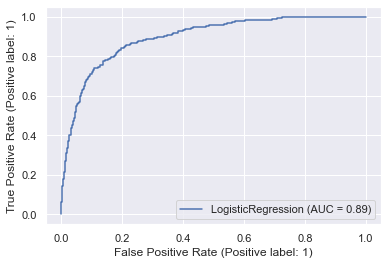

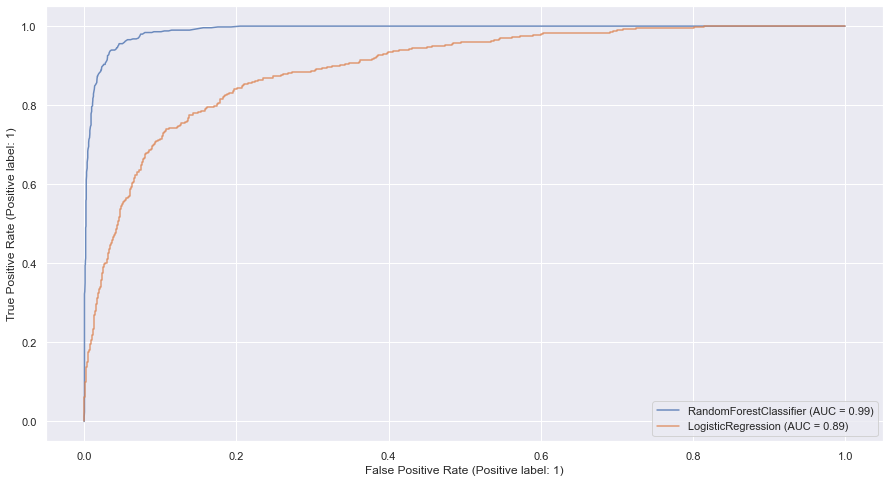

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


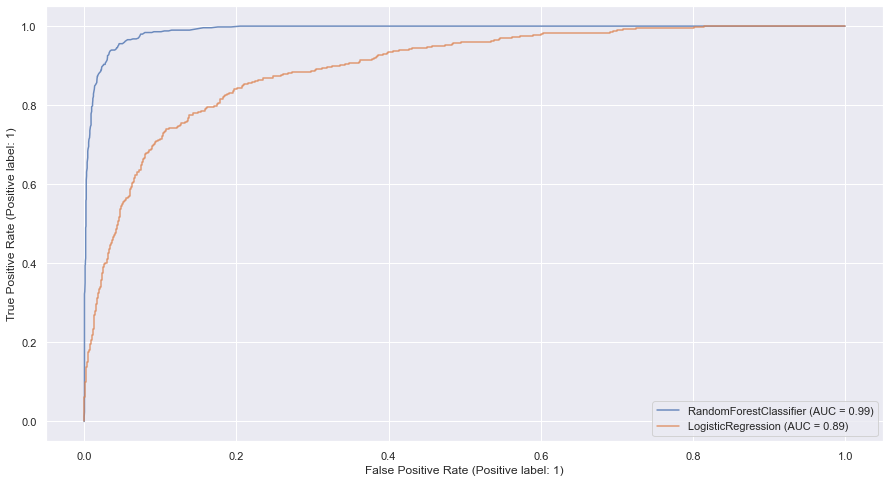

NameError: name 'cv_rfc' is not defined

In [ ]:
test_model()


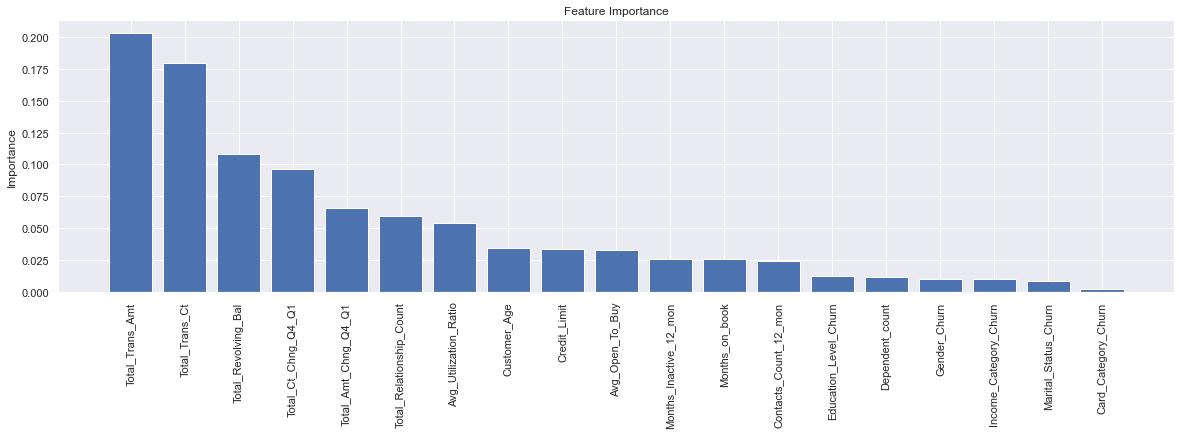

In [ ]:
def feature_importances():

    rfc_model = joblib.load('./models/rfc_model.pkl')
    lr_model = joblib.load('./models/logistic_model.pkl')
    # Calculate feature importances
    importances = cv_rfc.best_estimator_.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = [X_train.columns[i] for i in indices]

    # Create plot
    plt.figure(figsize=(20, 5))

    # Create plot title
    plt.title("Feature Importance")
    plt.ylabel('Importance')

    # Add bars
    plt.bar(range(X.shape[1]), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(X.shape[1]), names, rotation=90)


feature_importances()


In [ ]:
def result():
    plt.rc('figure', figsize=(5, 5))
    # plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
    plt.text(0.01, 1.25, str('Random Forest Train'), {
             'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {
             'fontsize': 10}, fontproperties='monospace')  # approach improved by OP -> monospace!
    plt.text(0.01, 0.6, str('Random Forest Test'), {
             'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {
             'fontsize': 10}, fontproperties='monospace')  # approach improved by OP -> monospace!
    plt.axis('off')

    plt.rc('figure', figsize=(5, 5))
    plt.text(0.01, 1.25, str('Logistic Regression Train'),
             {'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {
             'fontsize': 10}, fontproperties='monospace')  # approach improved by OP -> monospace!
    plt.text(0.01, 0.6, str('Logistic Regression Test'), {
             'fontsize': 10}, fontproperties='monospace')
    plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {
             'fontsize': 10}, fontproperties='monospace')  # approach improved by OP -> monospace!
    plt.axis('off')


NameError: name 'y_test' is not defined

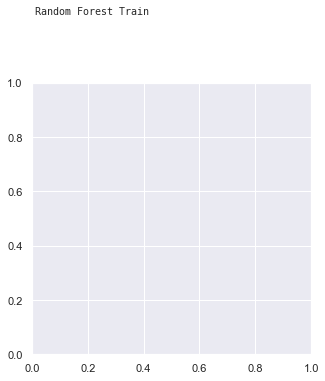

In [ ]:
result()
